In [33]:
from typing import Optional
import warnings
# Disable annoying warnings from PyArrow using under the hood.
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

import tensorflow as tf
import dask.dataframe as dd
from waymo_open_dataset import v2

# Path to the directory with all components
dataset_dir = '../../../Datasets/waymo/waymo_open_dataset_v_2_0_1/validation'

context_names = []
for filename in os.listdir(os.path.join(dataset_dir, 'stats')):
    if filename.endswith('.parquet'):
        context_names.append(filename.split('.')[0])

# context_name = '10023947602400723454_1120_000_1140_000'
context_name = '11940460932056521663_1760_000_1780_000'

def read(context_name, tag: str) -> dd.DataFrame:
    """Creates a Dask DataFrame for the component specified by its tag."""
    paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
    return dd.read_parquet(paths)


In [34]:
total_cam_images = 0
for cn in context_names:
    cam_image_df = read(cn, 'camera_segmentation')
    num_images = cam_image_df.shape[0].compute()
    total_cam_images += num_images
    print(f'{cn} camera_segmentation count: {num_images}')
print(f'Total camera_segmentation count: {total_cam_images}')

12831741023324393102_2673_230_2693_230 camera_segmentation count: 495
5574146396199253121_6759_360_6779_360 camera_segmentation count: 0
16229547658178627464_380_000_400_000 camera_segmentation count: 0
3077229433993844199_1080_000_1100_000 camera_segmentation count: 0
14262448332225315249_1280_000_1300_000 camera_segmentation count: 0
10359308928573410754_720_000_740_000 camera_segmentation count: 0
8398516118967750070_3958_000_3978_000 camera_segmentation count: 0
1505698981571943321_1186_773_1206_773 camera_segmentation count: 0
14107757919671295130_3546_370_3566_370 camera_segmentation count: 0
16213317953898915772_1597_170_1617_170 camera_segmentation count: 0
18331704533904883545_1560_000_1580_000 camera_segmentation count: 0
17626999143001784258_2760_000_2780_000 camera_segmentation count: 0
13982731384839979987_1680_000_1700_000 camera_segmentation count: 300
14486517341017504003_3406_349_3426_349 camera_segmentation count: 0
10448102132863604198_472_000_492_000 camera_segmenta

In [2]:
# Lazily read camera images and boxes 
cam_image_df = read(context_name, 'camera_image')
cam_box_df = read(context_name, 'camera_box')

# Combine DataFrame for individual components into a single DataFrame.

# Camera cam_box_df will be grouped, so each row will have a camera image
# and all associated boxes.
image_w_box_df = v2.merge(cam_image_df, cam_box_df, right_group=True)

# Show raw data
image_w_box_df.head()

# Example how to access data fields via v2 object-oriented API
print(f'Available {image_w_box_df.shape[0].compute()} rows:')
for i, (_, r) in enumerate(image_w_box_df.iterrows()):
    # Create component dataclasses for the raw data
    cam_image = v2.CameraImageComponent.from_dict(r)
    cam_box = v2.CameraBoxComponent.from_dict(r)
    print(
        f'context_name: {cam_image.key.segment_context_name}'
        f' ts: {cam_image.key.frame_timestamp_micros}'
        f' camera_name: {cam_image.key.camera_name}'
        f' image size: {len(cam_image.image)} bytes.'
        f' Has {len(cam_box.key.camera_object_id)} camera labels:'
    )

    for j, (object_id, x, y) in enumerate(zip(
        cam_box.key.camera_object_id, cam_box.box.center.x, cam_box.box.center.y
    )):
        print(f'\tid: {object_id},  center: ({x:.1f}, {y:.1f}) px')
        if j > 2:
            print('\t...')
            break
        if i > 2:
            print('...')
            break

Available 982 rows:
context_name: 11940460932056521663_1760_000_1780_000 ts: 1558483897522778 camera_name: 1 image size: 368047 bytes. Has 50 camera labels:
	id: 0012a2e3-b9a5-40c0-a1ee-623b239c0e86,  center: (796.4, 653.1) px
	id: 00bab776-fd12-45de-841b-ed41e878ad11,  center: (1010.5, 623.4) px
	id: 134ff59f-7b6a-4606-971c-f621d1fac4c4,  center: (961.0, 594.0) px
	id: 15f29847-8c32-473b-ba72-589766c2daaf,  center: (1057.9, 670.7) px
	...
context_name: 11940460932056521663_1760_000_1780_000 ts: 1558483897522778 camera_name: 2 image size: 389496 bytes. Has 16 camera labels:
	id: 0532f40d-4e6d-499a-aa04-367408272acb,  center: (1528.4, 711.2) px
	id: 0fd522b3-01e2-48e3-bb2a-08e70e7bbc4b,  center: (1367.4, 703.0) px
	id: 488d9fba-0d61-4039-afc1-ef556dec221c,  center: (269.1, 616.4) px
	id: 551dd581-7d39-42a2-9da7-a3f931fbdaeb,  center: (185.7, 611.4) px
	...
context_name: 11940460932056521663_1760_000_1780_000 ts: 1558483897522778 camera_name: 4 image size: 306900 bytes. Has 41 camera lab

In [3]:
#@title Sensor data with both lidar and camera boxes

# Lazily read camera images and boxes 
association_df = read(context_name, 'camera_to_lidar_box_association')
cam_box_df = read(context_name, 'camera_box')
cam_image_df = read(context_name, 'camera_image')
cam_segmentation_df = read(context_name, 'camera_segmentation')
lidar_box_df = read(context_name, 'lidar_box')
lidar_calibration_df = read(context_name, 'lidar_calibration')
lidar_df = read(context_name, 'lidar')


# Combine DataFrame for individual components into a single DataFrame.

# Camera cam_box_df will be grouped, so each row will have a camera image
# and all associated boxes.
cam_df = v2.merge(cam_image_df, cam_segmentation_df)
cam_image_w_box_df = v2.merge(cam_box_df, cam_df)
cam_obj_df = v2.merge(association_df, cam_image_w_box_df)
obj_df = v2.merge(cam_obj_df, lidar_box_df)
combined_lidar_df = v2.merge(lidar_df, lidar_calibration_df)
combined_df = v2.merge(lidar_df, obj_df, left_group=True, right_group=True)

# Read a single row, which contain data for all data for a single frame.
_, row = next(iter(combined_df.iterrows()))
# Create all component objects
camera_image = v2.CameraImageComponent.from_dict(row)
lidar = v2.LiDARComponent.from_dict(row)
camera_box = v2.CameraBoxComponent.from_dict(row)
lidar_box = v2.LiDARBoxComponent.from_dict(row)

print(
    f'Found {len(lidar_box.key.laser_object_id)} objects on'
    f' {lidar.key.segment_context_name=} {lidar.key.frame_timestamp_micros=}'
)
for laser_object_id, camera_object_id, camera_name in zip(
    lidar_box.key.laser_object_id,
    camera_box.key.camera_object_id,
    camera_image.key.camera_name,
):
    print(f'\t{laser_object_id=} {camera_object_id=} {camera_name=}')

StopIteration: 

In [17]:
obj_df.compute()

,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,key.camera_object_id,key.laser_object_id,[CameraBoxComponent].box.center.x,[CameraBoxComponent].box.center.y,[CameraBoxComponent].box.size.x,[CameraBoxComponent].box.size.y,[CameraBoxComponent].type,...,[LiDARBoxComponent].num_lidar_points_in_box,[LiDARBoxComponent].num_top_lidar_points_in_box,[LiDARBoxComponent].speed.x,[LiDARBoxComponent].speed.y,[LiDARBoxComponent].speed.z,[LiDARBoxComponent].acceleration.x,[LiDARBoxComponent].acceleration.y,[LiDARBoxComponent].acceleration.z,[LiDARBoxComponent].difficulty_level.detection,[LiDARBoxComponent].difficulty_level.tracking


In [20]:
cam_segmentation_df.compute()

,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,[CameraSegmentationLabelComponent].panoptic_label_divisor,[CameraSegmentationLabelComponent].panoptic_label,[CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.local_instance_ids,[CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.global_instance_ids,[CameraSegmentationLabelComponent].instance_id_to_global_id_mapping.is_tracked,[CameraSegmentationLabelComponent].sequence_id,[CameraSegmentationLabelComponent].num_cameras_covered
index,,,,,,,,,,


In [21]:
cam_image_df.compute()

,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,[CameraImageComponent].image,[CameraImageComponent].pose.transform,[CameraImageComponent].velocity.linear_velocity.x,[CameraImageComponent].velocity.linear_velocity.y,[CameraImageComponent].velocity.linear_velocity.z,[CameraImageComponent].velocity.angular_velocity.x,[CameraImageComponent].velocity.angular_velocity.y,[CameraImageComponent].velocity.angular_velocity.z,[CameraImageComponent].pose_timestamp,[CameraImageComponent].rolling_shutter_params.shutter,[CameraImageComponent].rolling_shutter_params.camera_trigger_time,[CameraImageComponent].rolling_shutter_params.camera_readout_done_time
index,,,,,,,,,,,,,,,
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.1586657285921245, -0.9868097192725985, 0.0...",-0.857379,5.706398,-0.029444,-0.033350,0.001521,0.035021,1.558484e+09,0.000720,1.558484e+09,1.558484e+09
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.15838171972118795, -0.9868428418493882, 0....",-0.877414,5.671050,-0.017514,-0.026137,0.009773,0.026227,1.558484e+09,0.000706,1.558484e+09,1.558484e+09
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.15809769774516483, -0.9868820223862939, 0....",-0.886972,5.664289,-0.023667,-0.016746,0.006503,0.026426,1.558484e+09,0.000832,1.558484e+09,1.558484e+09
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.15894950948351474, -0.9867768918193516, 0....",-0.871592,5.719006,-0.025583,-0.028014,0.004944,0.026917,1.558484e+09,0.000846,1.558484e+09,1.558484e+09
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.15942274651465776, -0.9867163008744527, 0....",-0.877519,5.743771,-0.024268,-0.027595,0.006613,0.027338,1.558484e+09,0.001058,1.558484e+09,1.558484e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11940460932056521663_1760_000_1780_000;1558483917222033,11940460932056521663_1760_000_1780_000,1558483917222033,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.16261028593435917, -0.9863100443865127, 0....",-1.634701,10.036650,0.205451,-0.019290,-0.001440,0.002519,1.558484e+09,0.000664,1.558484e+09,1.558484e+09
11940460932056521663_1760_000_1780_000;1558483917222033,11940460932056521663_1760_000_1780_000,1558483917222033,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.16261059911290096, -0.9863051577409478, 0....",-1.640807,10.033316,0.204317,-0.021746,-0.002331,-0.001220,1.558484e+09,0.001128,1.558484e+09,1.558484e+09
11940460932056521663_1760_000_1780_000;1558483917222033,11940460932056521663_1760_000_1780_000,1558483917222033,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[-0.16261059911290096, -0.986299853724962, 0.0...",-1.629751,10.037751,0.200199,-0.025359,-0.005115,0.004899,1.558484e+09,0.001381,1.558484e+09,1.558484e+09


In [22]:
lidar_df.compute()

,key.segment_context_name,key.frame_timestamp_micros,key.laser_name,[LiDARComponent].range_image_return1.values,[LiDARComponent].range_image_return1.shape,[LiDARComponent].range_image_return2.values,[LiDARComponent].range_image_return2.shape
index,,,,,,,
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,1,"[21.090868, 0.017089844, 0.13467239, -1.0, 21....","[64, 2650, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[64, 2650, 4]"
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,2,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]"
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,3,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]"
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,4,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]"
11940460932056521663_1760_000_1780_000;1558483897522778,11940460932056521663_1760_000_1780_000,1558483897522778,5,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]"
...,...,...,...,...,...,...,...
11940460932056521663_1760_000_1780_000;1558483917222033,11940460932056521663_1760_000_1780_000,1558483917222033,1,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[64, 2650, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[64, 2650, 4]"
11940460932056521663_1760_000_1780_000;1558483917222033,11940460932056521663_1760_000_1780_000,1558483917222033,2,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]"
11940460932056521663_1760_000_1780_000;1558483917222033,11940460932056521663_1760_000_1780_000,1558483917222033,3,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[200, 600, 4]"


In [5]:
from waymo_open_dataset.v2.perception.context import LiDARCalibrationComponent, BeamInclination
from waymo_open_dataset.v2.perception.base import SegmentLaserKey
from waymo_open_dataset.v2.perception.lidar import RangeImage
from waymo_open_dataset.v2.perception.context import Intrinsic
from waymo_open_dataset.v2 import column_types
from typing import Iterable

def extract_lidar_calib(lidar_calibration: LiDARCalibrationComponent) -> Iterable[LiDARCalibrationComponent]:
    for i in range(len(lidar_calibration.key.laser_name)):
        extrinsic = column_types.Transform(
            transform=lidar_calibration.extrinsic.transform[i],
        )
        beam_inclination = BeamInclination(
            min=lidar_calibration.beam_inclination.min[i],
            max=lidar_calibration.beam_inclination.max[i],
            values=lidar_calibration.beam_inclination.values[i],
        )
        yield LiDARCalibrationComponent(
            key=SegmentLaserKey(
                segment_context_name=lidar_calibration.key.segment_context_name,
                laser_name=lidar_calibration.key.laser_name[i],
            ),
            extrinsic=extrinsic,
            beam_inclination=beam_inclination,
        )

def extract_range_image(range_image: RangeImage) -> Iterable[RangeImage]:
    for i in range(len(range_image.values)):
        yield RangeImage(
            shape=range_image.shape[i],
            values=range_image.values[i],
        )

def extract_intrinsic(intrinsic: Intrinsic) -> Iterable[Intrinsic]:
    for i in range(len(intrinsic.f_u)):
        yield Intrinsic(
            f_u=intrinsic.f_u[i],
            f_v=intrinsic.f_v[i],
            c_u=intrinsic.c_u[i],
            c_v=intrinsic.c_v[i],
            k1=intrinsic.k1[i],
            k2=intrinsic.k2[i],
            p1=intrinsic.p1[i],
            p2=intrinsic.p2[i],
            k3=intrinsic.k3[i],
        )

def extract_transform(transform: column_types.Transform) -> Iterable[column_types.Transform]:
    for i in range(len(transform)):
        yield column_types.Transform(
            transform=transform[i],
        )

def waymo_intrinsic_to_matrix_and_distortion(intrinsic: Intrinsic) -> np.ndarray:
    return np.array([
        [intrinsic.f_u, 0, intrinsic.c_u],
        [0, intrinsic.f_v, intrinsic.c_v],
        [0, 0, 1],
    ]), np.array([intrinsic.k1, intrinsic.k2, intrinsic.p1, intrinsic.p2, intrinsic.k3])


In [6]:
#@title Export to rerun

# Lazily read camera images and boxes 
association_df = read(context_name, 'camera_to_lidar_box_association')
cam_box_df = read(context_name, 'camera_box')
cam_image_df = read(context_name, 'camera_image')
cam_segmentation_df = read(context_name, 'camera_segmentation')
cam_calibration_df = read(context_name, 'camera_calibration')
lidar_box_df = read(context_name, 'lidar_box')
lidar_calibration_df = read(context_name, 'lidar_calibration')
lidar_df = read(context_name, 'lidar')


# Combine DataFrame for individual components into a single DataFrame.

# Camera cam_box_df will be grouped, so each row will have a camera image
# and all associated boxes.
cam_df = v2.merge(cam_image_df, cam_segmentation_df)
cam_df = v2.merge(cam_df, cam_calibration_df)
cam_df = v2.merge(cam_df, cam_box_df)
cam_obj_df = v2.merge(association_df, cam_df)
obj_df = v2.merge(cam_obj_df, lidar_box_df)
combined_lidar_df = v2.merge(lidar_df, lidar_calibration_df)
combined_df = v2.merge(combined_lidar_df, obj_df, left_group=True, right_group=True)

# Show raw data
combined_df.head()

,key.segment_context_name,key.frame_timestamp_micros,key.laser_name,[LiDARComponent].range_image_return1.values,[LiDARComponent].range_image_return1.shape,[LiDARComponent].range_image_return2.values,[LiDARComponent].range_image_return2.shape,[LiDARCalibrationComponent].extrinsic.transform,[LiDARCalibrationComponent].beam_inclination.min,[LiDARCalibrationComponent].beam_inclination.max,...,[LiDARBoxComponent].num_lidar_points_in_box,[LiDARBoxComponent].num_top_lidar_points_in_box,[LiDARBoxComponent].speed.x,[LiDARBoxComponent].speed.y,[LiDARBoxComponent].speed.z,[LiDARBoxComponent].acceleration.x,[LiDARBoxComponent].acceleration.y,[LiDARBoxComponent].acceleration.z,[LiDARBoxComponent].difficulty_level.detection,[LiDARBoxComponent].difficulty_level.tracking
0,10023947602400723454_1120_000_1140_000,1552440197761529,"[1, 2, 3, 4, 5]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-0.8504865341879281, -0.5259818651729412, -0...","[-0.312798929102049, -1.5707963267948966, -1.5...","[0.04217103487285523, 0.5235987755982988, 0.52...",...,"[44, 94, 55, 52, 44, 69, 48, 17, 72, 28, 42, 5...","[44, 94, 55, 52, 44, 70, 48, 17, 72, 28, 42, 5...","[1.3590813086596931, 0.003069660913279648, 1.2...","[1.272735637703022, 0.002575100842534539, -0.6...","[0.032543497708275027, -0.006214923729661592, ...","[-0.2382723020627253, -2.1636026303895048e-10,...","[-0.17851014288794428, -1.8758328224066642e-10...","[-0.05299494237478441, 4.371614181764016e-10, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,10023947602400723454_1120_000_1140_000,1552440198161543,"[1, 2, 3, 4, 5]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-0.8504865341879281, -0.5259818651729412, -0...","[-0.312798929102049, -1.5707963267948966, -1.5...","[0.04217103487285523, 0.5235987755982988, 0.52...",...,"[69, 96, 0, 55, 63, 56, 55, 52, 18, 69, 24, 71...","[70, 96, 0, 55, 63, 56, 55, 52, 18, 69, 24, 71...","[1.2805335597575684, 0.003069660887646819, -0....","[1.231884167472117, 0.0025751008223551253, 1.0...","[0.010914921995510696, -0.0062149236775432826,...","[-0.2008624014326443, 1.5090151350705125e-10, ...","[0.01103874584771347, 1.222133505507372e-10, -...","[-0.09795878827922876, -3.058886477447231e-10,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,10023947602400723454_1120_000_1140_000,1552440198361627,"[1, 2, 3, 4, 5]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-0.8504865341879281, -0.5259818651729412, -0...","[-0.312798929102049, -1.5707963267948966, -1.5...","[0.04217103487285523, 0.5235987755982988, 0.52...",...,"[72, 100, 5, 55, 25, 58, 74, 51, 18, 80, 24, 6...","[72, 100, 5, 55, 25, 58, 74, 52, 18, 80, 24, 6...","[1.2500407953735326, 0.00306966096456307, -0.9...","[1.2345145916987121, 0.0025751008894303595, 1....","[-0.004025871653503543, -0.0062149238336139945...","[-0.150141733956044, -2.664535259100375e-13, -...","[0.0313296761987658, -4.2632564145606e-12, -0....","[-0.0749086501791396, 4.4408920985006257e-13, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,10023947602400723454_1120_000_1140_000,1552440198561742,"[1, 2, 3, 4, 5]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4], [200, 600, 4], [200, 600, 4], ...","[[-0.8504865341879281, -0.5259818651729412, -0...","[-0.3

In [7]:
# print(f'Available {combined_df.shape[0].compute()} rows:')
import rerun as rr
import os
rerun_output_path = f'waymo.rrd'
rerun_output_filename = os.path.basename(rerun_output_path)
rr.init(rerun_output_filename)

for i, (k, r) in enumerate(combined_df.iterrows()):
    print(i)
    ts = cam_image.key.frame_timestamp_micros
    rr.set_time_sequence(f'frame', i)
    rr.set_time_sequence(f'ts', ts)
    # Create component dataclasses for the raw data
    cam_image = v2.CameraImageComponent.from_dict(r)
    cam_seg = v2.CameraSegmentationLabelComponent.from_dict(r)
    cam_calib = v2.CameraCalibrationComponent.from_dict(r)
    cam_box = v2.CameraBoxComponent.from_dict(r)
    lidar = v2.LiDARComponent.from_dict(r)
    lidar_calib = v2.LiDARCalibrationComponent.from_dict(r)
    lidar_calib = list(extract_lidar_calib(lidar_calib))
    
    intrinsics = list(extract_intrinsic(cam_calib.intrinsic))
    extrinsics = list(extract_transform(cam_calib.extrinsic.transform))
    
    for camera_name, image, intrinsic, extrinsic in zip(cam_image.key.camera_name, cam_image.image, intrinsics, extrinsics):
        image = Image.open(io.BytesIO(image))
        rr.log(f'camera/{camera_name}', rr.Image(image))

        rr.log(f'camera/{camera_name}', rr.Transform3D(mat3x3=extrinsic.transform.reshape(4,4)[:3, :3]))
        
        intrinsic, distortion = waymo_intrinsic_to_matrix_and_distortion(intrinsic)
        rr.log(f'camera/{camera_name}', rr.Pinhole(image_from_camera=intrinsic))


    range_images = list(extract_range_image(lidar.range_image_return1))
    for laser_name, range_image, calib in zip(lidar.key.laser_name, range_images, lidar_calib):
        pcl = v2.convert_range_image_to_point_cloud(range_image=range_image, calibration=calib)
        pcl = pcl.numpy()
        rr.log(f'lidar/{laser_name}', rr.Points3D(pcl))

    if i > 2:
        break
rr.save(rerun_output_path)

0


I0000 00:00:1733256584.656252  736758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46764 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6
I0000 00:00:1733256584.657810  736758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46764 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:22:00.0, compute capability: 8.6
I0000 00:00:1733256584.659420  736758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46764 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:23:00.0, compute capability: 8.6
I0000 00:00:1733256584.660773  736758 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46764 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:24:00.0, compute capability: 8.6


1
2
3


In [8]:
pcl

array([[-3.12756872e+00, -2.32184052e+00,  1.28184545e+00],
       [-3.30627155e+00, -2.32814407e+00,  1.31100321e+00],
       [-1.55489264e+01,  6.11362886e+00,  4.22112417e+00],
       ...,
       [-1.36370444e+00, -5.11970110e-02,  2.80196965e-02],
       [-1.35526001e+00, -2.39483956e-02,  4.22965288e-02],
       [-1.35833418e+00, -1.28973005e-02,  3.74692678e-02]], dtype=float32)

In [9]:
cam_calib.intrinsic

Intrinsic(f_u=[2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2050.448325964014, 2050.448325964014, 2050.448325964014, 2062.8902645836733, 2062.8902645836733, 2059.3601413593224, 2059.3601413593224, 2059.3601413593224, 2059.3601413593224, 2059.3601413593224], f_v=[2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2060.1425931120934, 2050.448325964014, 2050.448325964014, 2050.448325964014, 2062.8902645836733, 2062.8902645836733, 2059.3601413593224, 2059.3601413593224, 2059.

In [10]:
extrinsic

Transform(transform=array([ 7.09757623e-01,  7.04445388e-01,  9.00998665e-04,  1.49082759e+00,
       -7.04439735e-01,  7.09756145e-01, -3.29752682e-03, -9.39506515e-02,
       -2.96241690e-03,  1.70574554e-03,  9.99994157e-01,  2.11606489e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]))

In [11]:
extrinsic

Transform(transform=array([ 7.09757623e-01,  7.04445388e-01,  9.00998665e-04,  1.49082759e+00,
       -7.04439735e-01,  7.09756145e-01, -3.29752682e-03, -9.39506515e-02,
       -2.96241690e-03,  1.70574554e-03,  9.99994157e-01,  2.11606489e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]))

(1920, 1280)


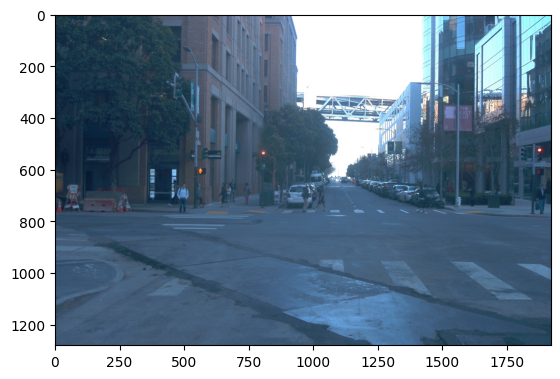

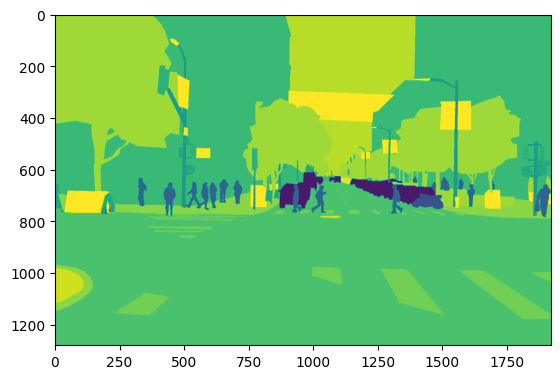

In [17]:

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import io

img = Image.open(io.BytesIO(camera_image.image[0]))
print(img.size)
plt.imshow(np.array(img))
plt.show()

img = Image.open(io.BytesIO(cam_seg.panoptic_label[0]))
plt.imshow(np.array(img))
plt.show()